In [1]:
import tensorflow as tf
import numpy as np
import math

In [2]:
def make_dictionary(data):
    words=set(data.split()) ## gets unique words only
    word2int={}
    int2word={}
    vocab_size=len(words)
    
    for i, word in enumerate(words):
        word2int[word]=i
        int2word[i]=word
    return word2int,int2word,vocab_size

In [3]:
def read_data(filename):
    with open(filename,'r') as f:
        return f.read()

url='/home/farrukh/Courses GIST/ML and DL/datasets/Word2Vec/text_train'
data=read_data(url)


In [4]:
word2int,int2word,vocabulari_size=make_dictionary(data)
embedding_size=128

In [5]:
## used for checking and debuggin 
#data='the quick brown fox jumped over the lazy dog'
#word2int,int2word,vocabulari_size=make_dictionary(data)
#embedding_size=5

In [22]:
len(word2int)

623

In [6]:
## makes stacked (context,target) tuples using window size of 1
def make_context_target_pairs(data,window_size=1):
    dataset=data.split()
    left=[dataset[i-window_size:i] for i in range(window_size,len(dataset)-window_size)]
    right=[dataset[i+1:i+window_size+1] for i in range(window_size,len(dataset)-window_size)]
    middle=[dataset[i] for i in range(window_size,len(dataset)-window_size)]
    dataset=[]
    for i in range(len(left)):
        combined=left[i]
        combined.extend(right[i])
        dataset.append((combined,middle[i]))
    return dataset

#makes unstacked (target_i,context_i_j) pairwise tuples
## where (target,context) is the same as (input,output) datasets for skip-grammar model
def make_pair(data):
    dataset=[]
    for i in range(len(data)):
        dataset.extend([[data[i][1],data[i][0][j]] for j in range(len(data[i][0])) ])
    return dataset
preprocessed=make_context_target_pairs(data,1)
invrtd_data=make_pair(preprocessed)
preprocessed,invrtd_data

([(['anarchism', 'as'], 'originated'),
  (['originated', 'a'], 'as'),
  (['as', 'term'], 'a'),
  (['a', 'of'], 'term'),
  (['term', 'abuse'], 'of'),
  (['of', 'first'], 'abuse'),
  (['abuse', 'used'], 'first'),
  (['first', 'against'], 'used'),
  (['used', 'early'], 'against'),
  (['against', 'working'], 'early'),
  (['early', 'class'], 'working'),
  (['working', 'radicals'], 'class'),
  (['class', 'including'], 'radicals'),
  (['radicals', 'the'], 'including'),
  (['including', 'diggers'], 'the'),
  (['the', 'of'], 'diggers'),
  (['diggers', 'the'], 'of'),
  (['of', 'english'], 'the'),
  (['the', 'revolution'], 'english'),
  (['english', 'and'], 'revolution'),
  (['revolution', 'the'], 'and'),
  (['and', 'sans'], 'the'),
  (['the', 'culottes'], 'sans'),
  (['sans', 'of'], 'culottes'),
  (['culottes', 'the'], 'of'),
  (['of', 'french'], 'the'),
  (['the', 'revolution'], 'french'),
  (['french', 'whilst'], 'revolution'),
  (['revolution', 'the'], 'whilst'),
  (['whilst', 'term'], 'the')

In [7]:
def replace_data_with_codes(data,word2int):
    dataset=[[word2int[inpt],word2int[outpt]] for inpt,outpt in data]
    return dataset
train_data=np.array(replace_data_with_codes(invrtd_data,word2int))
train_data

array([[  4,  80],
       [  4, 280],
       [280,   4],
       ...,
       [544, 390],
       [390, 544],
       [390, 503]])

In [8]:
embeddings=tf.Variable(tf.random_uniform([vocabulari_size,embedding_size],-1.0,1.0))
nce_weights=tf.Variable(tf.truncated_normal([vocabulari_size,embedding_size],
                                           stddev=1.0/math.sqrt(embedding_size)))
nce_biases=tf.Variable(tf.zeros([vocabulari_size]))

In [9]:
norm=tf.sqrt(tf.reduce_sum(tf.square(embeddings),1,keepdims=True))
normalized_embeddings=embeddings/norm
#valid_embeddings=tf.nn.embedding_lookup(normalized_embeddings,valid_dataset)

In [10]:
batch_size=397
train_input=tf.placeholder(tf.int32,shape=[batch_size])
train_labels=tf.placeholder(tf.int32,shape=[batch_size,1])

In [11]:
embed=tf.nn.embedding_lookup(embeddings,train_input)

In [12]:
loss=tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,
                                  biases=nce_biases,
                                  labels=train_labels,
                                  inputs=embed,
                                  num_classes=vocabulari_size,
                                  num_sampled=2))


W0724 16:07:17.810012 140171918968640 deprecation.py:323] From /home/farrukh/.local/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
optimizer=tf.train.GradientDescentOptimizer(learning_rate=1.0)
training_op=optimizer.minimize(loss)


In [14]:
def generate_batch(data,batch_size):
    x=data[:,:1].reshape(len(data)).copy()
    y=data[:,1:].copy()
    indecis=np.random.permutation(len(data),)
    n_batches=len(data)//batch_size
    for ind in np.array_split(indecis,n_batches):
        return x[ind], y[ind]

In [15]:
len(train_data)

3176

In [16]:
init=tf.global_variables_initializer()
with tf.Session() as sess:
    init.run()
    print(embeddings.eval(),'\n\n')

    for epoch in range(10000):
        for i in range(len(train_data)):
            x_batch,y_batch=generate_batch(train_data,batch_size)
            feed_dict={train_input:x_batch,train_labels:y_batch}
            _,cur_loss=sess.run([training_op,loss], feed_dict=feed_dict)
        if(epoch%100==0):
            print('Epoch: %d out of 10000'%epoch)
    print(embeddings.eval(),'\n\n\n\n')
    final_embeddings=normalized_embeddings.eval()

[[-0.31231594 -0.02439237 -0.31931877 ...  0.29327822 -0.40518737
  -0.6823218 ]
 [ 0.3128214   0.140625   -0.09627461 ... -0.15566587  0.57449365
   0.17890143]
 [ 0.74186444  0.8628664  -0.26462364 ... -0.0906198  -0.24038124
   0.89461756]
 ...
 [ 0.18550539  0.02300668  0.617671   ...  0.52190423 -0.71806765
   0.20292425]
 [-0.6248145  -0.09559965  0.7897382  ... -0.9264929   0.05969739
   0.28758478]
 [-0.25663447  0.45828676 -0.65050197 ... -0.522661    0.32393003
   0.16653132]] 


Epoch: 0 out of 10000
Epoch: 100 out of 10000
Epoch: 200 out of 10000
Epoch: 300 out of 10000
Epoch: 400 out of 10000
Epoch: 500 out of 10000
Epoch: 600 out of 10000
Epoch: 700 out of 10000
Epoch: 800 out of 10000
Epoch: 900 out of 10000
Epoch: 1000 out of 10000
Epoch: 1100 out of 10000
Epoch: 1200 out of 10000
Epoch: 1300 out of 10000
Epoch: 1400 out of 10000
Epoch: 1500 out of 10000
Epoch: 1600 out of 10000
Epoch: 1700 out of 10000
Epoch: 1800 out of 10000
Epoch: 1900 out of 10000
Epoch: 2000 out o

In [17]:
final_embeddings

array([[-0.02793087,  0.09050193,  0.00848256, ..., -0.05449597,
        -0.06303503, -0.02807044],
       [ 0.02473526,  0.0428573 ,  0.08577666, ..., -0.08545546,
         0.02648543,  0.07409813],
       [ 0.11120948,  0.14105804, -0.01938956, ..., -0.05415259,
        -0.00062657,  0.15309444],
       ...,
       [ 0.05164175, -0.08638589,  0.09296851, ...,  0.09186128,
        -0.08041609,  0.06079501],
       [-0.07805571, -0.03350911,  0.09015675, ..., -0.1523486 ,
         0.07259317,  0.10754663],
       [-0.04218265,  0.10032891, -0.16242217, ...,  0.05650855,
         0.19112925,  0.06326716]], dtype=float32)

In [18]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [19]:
def plot_with_labels(low_dim_embs,labels):
    plt.figure(figsize=(18,18))
    for i, label in enumerate(labels):
        x,y=low_dim_embs[i,:]
        plt.scatter(x,y)
        plt.annotate(label,
                   xy=(x,y),
                   xytext=(5,2),
                   textcoords='offset points',
                   ha='right',
                   va='bottom')
    plt.savefig('/home/farrukh/Courses GIST/ML and DL/datasets/Word2Vec/pic.png')

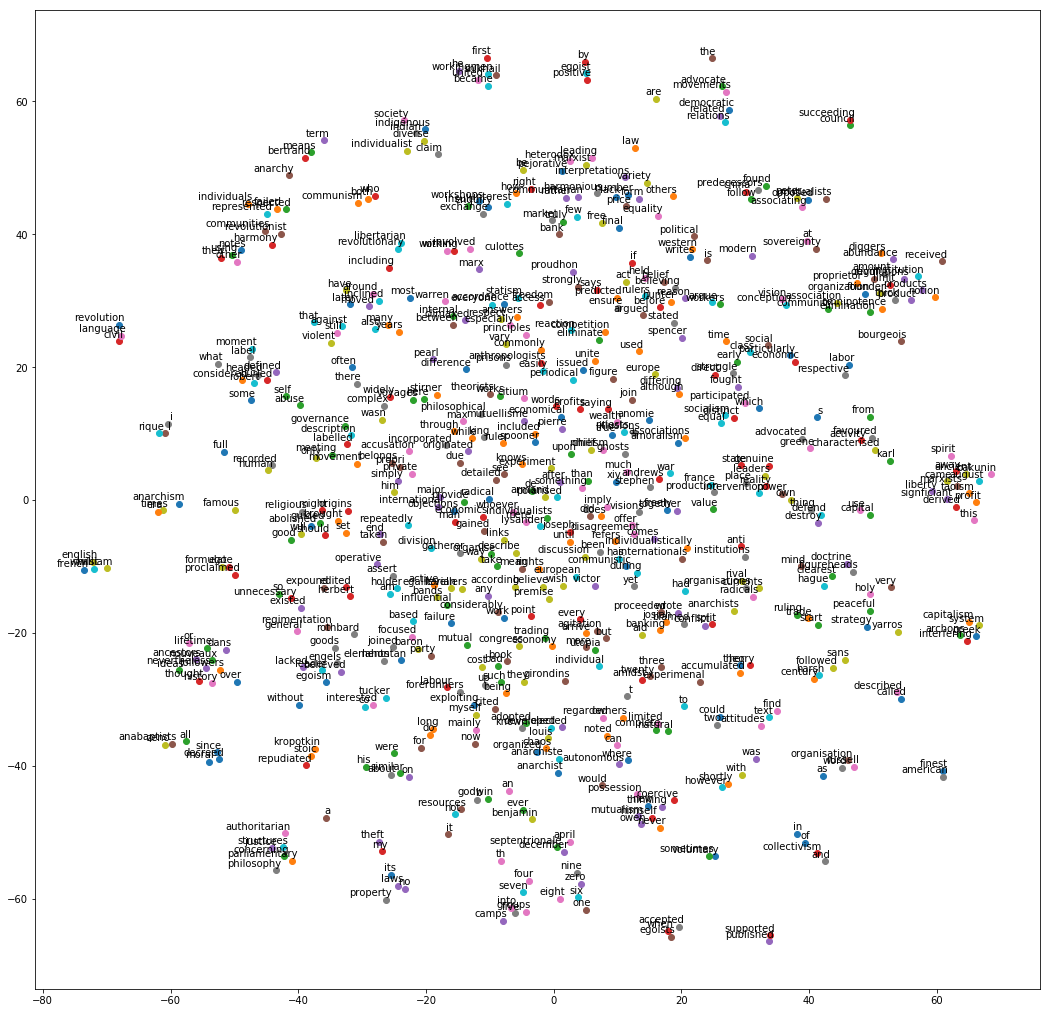

In [23]:
tsne=TSNE(perplexity=32,n_components=2,init='pca',n_iter=5000,
         method='exact')
plot_only=623
low_dim_embs=tsne.fit_transform(final_embeddings[:plot_only,:])
labels=[int2word[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs,labels)